# Finding Useful Features/Variables/Input

A regression model that has fewer input/independent variables is often desirable for simplicity and explainability. It is often referred to as having a **parsimonius** model. See this article for more details on the "[law of parsimony][1]".

Let's try a few different ways to find the "best" model using our customer dataset.

[1]: https://en.wikipedia.org/wiki/Occam%27s_razor

In [1]:
# Import our most-used packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Import useful ones from the sklearn package 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## RFE classes
from sklearn.feature_selection import RFE, RFECV

## Other classes for linear models
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV

# Scaling
from sklearn.preprocessing import StandardScaler

# Import statsmodels stuff
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

## The Data
We have been given sample data from our customers. The data has been aggregated from individual purchases / transactions across the time period (e.g., last year). The goal is to see if we can predict the spending amounts for the next time period (e.g., next year).

In [2]:
# Read in the data and print out its shape
cust = pd.read_csv('./data/customers_clean.csv')
print(cust.shape)

(12266, 11)


In [3]:
# Look at info
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   cust_id             12266 non-null  object
 1   join_date           12266 non-null  object
 2   gender              12266 non-null  object
 3   age                 12266 non-null  int64 
 4   marital_status      12266 non-null  object
 5   household_income    12266 non-null  int64 
 6   home_ownership      12266 non-null  object
 7   num_children        12266 non-null  int64 
 8   num_vehicles        12266 non-null  int64 
 9   last_purchase_date  12266 non-null  object
 10  spend               12266 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 1.0+ MB


In [4]:
# Sample the data
cust.sample(5)

,cust_id,join_date,gender,age,marital_status,household_income,home_ownership,num_children,num_vehicles,last_purchase_date,spend
7505,CUST-224655,2017-02-04 09:22:12,M,52,married,296280,own,2,0,2021-07-18 17:14:38,5262
401,CUST-007588,2017-02-07 21:08:36,F,20,unmarried,467702,rent,3,5,2021-10-07 19:20:39,1883
12113,CUST-942258,2019-02-15 07:15:12,F,43,married,410940,own,0,1,2021-02-20 05:42:32,5332
4175,CUST-030308,2018-07-30 09:07:13,M,21,married,331618,rent,4,3,2021-01-27 19:43:45,3750
10139,CUST-921946,2018-05-17 13:08:35,M,56,married,92996,rent,0,3,2021-04-19 04:50:41,2565


In [5]:
# See summary statistics
cust.describe()

,age,household_income,num_children,num_vehicles,spend
count,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000
mean,37.864096,301670.381135,2.505544,2.503913,4156.452715
std,10.663234,115752.377718,1.707281,1.697419,1585.348162
min,20.000000,65003.000000,0.000000,0.000000,1468.000000
25%,29.000000,217028.250000,1.000000,1.000000,2788.250000
50%,38.000000,307364.500000,3.000000,3.000000,4169.000000
75%,47.000000,399456.250000,4.000000,4.000000,5296.000000
max,56.000000,489982.000000,5.000000,5.000000,7314.000000


## End Result for Input
We want to have all numerical variables. This means we should create *dummy* variables for `gender`, `marital_status`, and `home_ownership`. We also do not need `cust_id` since it is just a unique id (now that we have dropped duplicates). The two date columns could be used to create numerical values, but we will simply ignore them for now.

In [6]:
# Let's drop the following columns:
# cust_id, join_date, last_purchase_date
new_cust = cust.drop(columns=['cust_id','join_date','last_purchase_date'])
new_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            12266 non-null  object
 1   age               12266 non-null  int64 
 2   marital_status    12266 non-null  object
 3   household_income  12266 non-null  int64 
 4   home_ownership    12266 non-null  object
 5   num_children      12266 non-null  int64 
 6   num_vehicles      12266 non-null  int64 
 7   spend             12266 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 766.8+ KB


## Create Dummy Variables

If your `DataFrame` contains categorical (or object) columns, you can call `pd.get_dummies(your_dataframe)` to create the dummy variables for **every** categorical column in the `DataFrame`. Since we deleted the "extra" columns, let's try it on our `new_cust` variable and see the results.

In [7]:
# Run it again and save it in a new DataFrame
data = pd.get_dummies(new_cust, dtype=int, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   age                       12266 non-null  int64
 1   household_income          12266 non-null  int64
 2   num_children              12266 non-null  int64
 3   num_vehicles              12266 non-null  int64
 4   spend                     12266 non-null  int64
 5   gender_M                  12266 non-null  int64
 6   marital_status_unmarried  12266 non-null  int64
 7   home_ownership_rent       12266 non-null  int64
 8   home_ownership_unknown    12266 non-null  int64
dtypes: int64(9)
memory usage: 862.6 KB


In [8]:
# Look at .describe()
data.describe()

,age,household_income,num_children,num_vehicles,spend,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000
mean,37.864096,301670.381135,2.505544,2.503913,4156.452715,0.315669,0.251834,0.252323,0.101582
std,10.663234,115752.377718,1.707281,1.697419,1585.348162,0.464801,0.434084,0.434364,0.302110
min,20.000000,65003.000000,0.000000,0.000000,1468.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,217028.250000,1.000000,1.000000,2788.250000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,307364.500000,3.000000,3.000000,4169.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,399456.250000,4.000000,4.000000,5296.000000,1.000000,1.000000,1.000000,0.000000
max,56.000000,489982.000000,5.000000,5.000000,7314.000000,1.000000,1.000000,1.000000,1.000000


## Split Data into Training and Test Sets

Need to first define `X` and `y`. Then we can try train/test split.

In [9]:
# define the output variable, y
y = data.spend

# define the X
X = data.drop('spend', axis=1)

In [10]:
# Time to split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=163)

In [11]:
# Look at shape of X_train
X_train.shape

(9812, 8)

In [12]:
# Look at shape of X_test
X_test.shape

(2454, 8)

In [13]:
# Kick out summary statistics for X_train
X_train.describe()

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,9812.000000,9812.000000,9812.000000,9812.000000,9812.000000,9812.000000,9812.000000,9812.000000
mean,37.848349,301149.021199,2.505605,2.504280,0.315430,0.251427,0.254484,0.098757
std,10.694793,115006.856292,1.704877,1.693242,0.464711,0.433855,0.435593,0.298350
min,20.000000,65003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,217586.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,306220.500000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,398203.000000,4.000000,4.000000,1.000000,1.000000,1.000000,0.000000
max,56.000000,489982.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# Kick out summary statistics for X_test
# Hope these are close to X_train stats
X_test.describe()

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000
mean,37.927058,303754.971068,2.505297,2.502445,0.316626,0.253464,0.243684,0.112877
std,10.538032,118687.464418,1.717210,1.714365,0.465255,0.435083,0.429392,0.316507
min,20.000000,65206.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,215343.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,312449.000000,3.000000,2.500000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,404501.250000,4.000000,4.000000,1.000000,1.000000,0.000000,0.000000
max,56.000000,489964.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
full_train = pd.concat([X_train, y_train], axis='columns')
full_train

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown,spend
3629,55,446885,2,2,1,1,0,0,2708
6118,55,189049,4,2,1,1,0,0,4926
11679,49,70696,5,4,0,0,1,0,3982
4993,23,487791,2,1,0,0,0,0,7310
12180,21,355187,0,1,0,1,0,0,4795
...,...,...,...,...,...,...,...,...,...
6870,20,193010,0,3,1,0,0,0,2966
8356,30,239213,1,1,0,0,0,0,4491
3055,56,293871,1,3,0,0,0,0,5495
4238,42,351179,0,3,1,0,0,0,2463


In [16]:
# Run a full regression model with statsmodels
# Create the RHS (the independent variables)
rhs = '+'.join([str(col) for col in X_train.columns])
print(rhs)

age+household_income+num_children+num_vehicles+gender_M+marital_status_unmarried+home_ownership_rent+home_ownership_unknown


In [17]:
# Full multiple linear regression with statsmodels
full_mlr = ols('spend ~ ' + rhs, data=full_train).fit()

In [18]:
full_mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     556.3
Date:                Mon, 25 Sep 2023   Prob (F-statistic):               0.00
Time:                        19:01:16   Log-Likelihood:                -84391.
No. Observations:                9812   AIC:                         1.688e+05
Df Residuals:                    9803   BIC:                         1.689e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 4390.9346     70.935     61.901      0.000    4251.888    4529.981
age                          0.6422      1.243      0.517      0.605      -1.794       3.079
household_income             0.0022      0.000     18.335      0.000       0.002       0.002
num_children                 1.5062      7.795      0.193      0.847     -13.774      16.786
num_vehicles                 2.4418      7.849      0.311      0.756     -12.943      17.827
gender_M                 -1035.0956     28.833    -35.899      0.000   -1091.615    -978.576
marital_status_unmarried  -867.0921     30.815    -28.138      0.000    -927.497    -806.688
home_ownership_rent      -1069.8124     31.409    -34.061      0.000   -1131.381   -1008.244
home_ownership_unknown   -1045.7841     45.611    -22.929      0.000   -1135.190    -956.378
==============================================================================
Omnibus:                      506.699   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.802
Skew:                          -0.259   Prob(JB):                     1.06e-61
Kurtosis:                       2.353   Cond. No.                     1.75e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

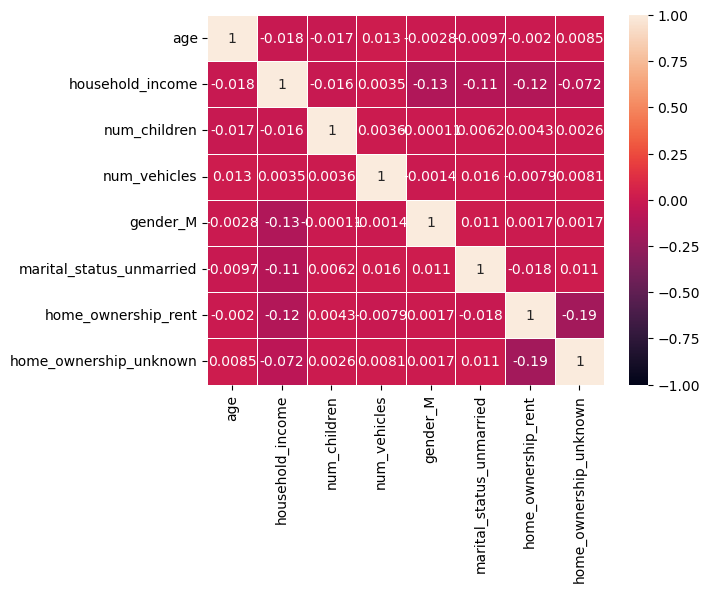

In [20]:
sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True, lw=0.5)

## Finding VIFs

Unfortunately, the `summary()` method does not include the VIFs for each variable. (Wouldn't that be nice!) We can, however, find them somewhat painlessly. The code cell below contains a function that will compute VIFs for the features/variables that are passed into it using the `X_train` dataset we created earlier.

In [21]:
# compute the vif for all given features
def compute_vif(considered_features):
    X = X_train[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [22]:
# Send the function all the columns from X_train
compute_vif(X_train.columns)

,Variable,VIF
0,age,1.001041
1,household_income,1.055120
2,num_children,1.000589
3,num_vehicles,1.000562
4,gender_M,1.017138
5,marital_status_unmarried,1.012634
6,home_ownership_rent,1.060476
7,home_ownership_unknown,1.049085


### What Does This Mean?

You tell me!

In [27]:
other_features = ['age','num_children','num_vehicles']
compute_vif(other_features)

/tmp/ipykernel_127/516561236.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,age,1.000460
1,num_children,1.000299
2,num_vehicles,1.000189


## We Should Scale the Data

Before we attempt to use RFE, Ridge, Lasso, or ElasticNet, we should scale the data. We will use the `StandardScaler` which makes each variable have a mean of 0 and a standard deviation of 1. It does not change the shape of the data. (Thought Exercise: How would you verify that statement?)

In [28]:
# Fit the scaler on just the training X variables
# Let's start with StandardScaler which will center
# each variable at 0 and give each a unit variance (=1)
s_scaler = StandardScaler().fit(X_train)
s_scaler

StandardScaler()

In [29]:
s_scaler.transform(X_train)

array([[ 1.60382026,  1.26725841, -0.29657933, ...,  1.72548554,
        -0.58425455, -0.33102598],
       [ 1.60382026, -0.97477435,  0.87658593, ...,  1.72548554,
        -0.58425455, -0.33102598],
       [ 1.04277097, -2.00392197,  1.46316856, ..., -0.57954702,
         1.71158272, -0.33102598],
       ...,
       [ 1.69732847, -0.06328659, -0.88316197, ..., -0.57954702,
        -0.58425455, -0.33102598],
       [ 0.38821347,  0.43503953, -1.4697446 , ..., -0.57954702,
        -0.58425455, -0.33102598],
       [ 1.51031205, -1.56514316, -0.88316197, ..., -0.57954702,
        -0.58425455, -0.33102598]])

In [30]:
# Transform X_train
X_train_ss = s_scaler.transform(X_train)
# Put it in a DataFrame using same column names
train_X_ss = pd.DataFrame(X_train_ss, columns=X_train.columns)

In [31]:
# Take a look at the DataFrame
train_X_ss

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
0,1.603820,1.267258,-0.296579,-0.297835,1.473185,1.725486,-0.584255,-0.331026
1,1.603820,-0.974774,0.876586,-0.297835,1.473185,1.725486,-0.584255,-0.331026
2,1.042771,-2.003922,1.463169,0.883391,-0.678801,-0.579547,1.711583,-0.331026
3,-1.388443,1.622960,-0.296579,-0.888448,-0.678801,-0.579547,-0.584255,-0.331026
4,-1.575459,0.469891,-1.469745,-0.888448,-0.678801,1.725486,-0.584255,-0.331026
...,...,...,...,...,...,...,...,...
9807,-1.668967,-0.940331,-1.469745,0.292778,1.473185,-0.579547,-0.584255,-0.331026
9808,-0.733885,-0.538569,-0.883162,-0.888448,-0.678801,-0.579547,-0.584255,-0.331026
9809,1.697328,-0.063287,-0.883162,0.292778,-0.678801,-0.579547,-0.584255,-0.331026
9810,0.388213,0.435040,-1.469745,0.292778,1.473185,-0.579547,-0.584255,-0.331026


In [32]:
# Summary statistics for scaled data
train_X_ss.describe()

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03
mean,4.924267e-17,-1.578662e-16,-6.626035e-17,-9.486455e-17,-4.127694e-17,6.752763e-17,-5.630320e-17,-1.375898e-17
std,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,-1.668967e+00,-2.053426e+00,-1.469745e+00,-1.479061e+00,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
25%,-8.273933e-01,-7.266243e-01,-8.831620e-01,-8.884476e-01,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
50%,1.418062e-02,4.409943e-02,2.900033e-01,2.927784e-01,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
75%,8.557545e-01,8.439403e-01,8.765859e-01,8.833914e-01,1.473185e+00,1.725486e+00,1.711583e+00,-3.310260e-01
max,1.697328e+00,1.642012e+00,1.463169e+00,1.474004e+00,1.473185e+00,1.725486e+00,1.711583e+00,3.020911e+00


## RFE 

Recursive feature elimination will rank the input variables if you tell it to only select a single feature. Let's try it and see what order it thinks the input variables add value to the regression.

In [33]:
# Run regression on the standardized data (mean=0, stdev=1)
mlr = LinearRegression()
rfe = RFE(mlr, n_features_to_select=1)

mlr.fit(rfe.fit_transform(train_X_ss, y_train), y_train)

LinearRegression()

In [35]:
X_train.columns

Index(['age', 'household_income', 'num_children', 'num_vehicles', 'gender_M',
       'marital_status_unmarried', 'home_ownership_rent',
       'home_ownership_unknown'],
      dtype='object')

In [34]:
# Print a boolean array called support_
# Because we had n_features_to_select=1, only one will be True
rfe.support_

array([False, False, False, False,  True, False, False, False])

In [36]:
# What order are the other input variables in?
rfe.ranking_

array([6, 5, 8, 7, 1, 3, 2, 4])

In [37]:
# Let's try to make sense of the ranking by matching each ranking
# with its column name
print('Input variables sorted by their rank:')

d = {}
for i in range(len(rfe.ranking_)):
    d[rfe.ranking_[i]] = train_X_ss.columns[i]
    
print(sorted(d.items()))

Input variables sorted by their rank:
[(1, 'gender_M'), (2, 'home_ownership_rent'), (3, 'marital_status_unmarried'), (4, 'home_ownership_unknown'), (5, 'household_income'), (6, 'age'), (7, 'num_vehicles'), (8, 'num_children')]


### 'Optimal' Number of Features?

Let's try RFECV that is supposed to find the "optimal" number of features for us

In [38]:
mlr_rfecv = LinearRegression()
rfecv = RFECV(mlr_rfecv)

mlr_rfecv.fit(rfecv.fit_transform(train_X_ss, y_train), y_train)
print(f'Optimal number of features: {rfecv.n_features_}')

Optimal number of features: 5


In [39]:
# Look at the support and ranking
print(rfecv.support_)
print(rfecv.ranking_)

[False  True False False  True  True  True  True]
[2 1 4 3 1 1 1 1]


In [40]:
# Print out all the variables that have a ranking of 1
for i in range(len(rfecv.ranking_)):
    if rfecv.ranking_[i] == 1:
        print(f'Ranking of 1: {train_X_ss.columns[i]}')

Ranking of 1: household_income
Ranking of 1: gender_M
Ranking of 1: marital_status_unmarried
Ranking of 1: home_ownership_rent
Ranking of 1: home_ownership_unknown


Notice that those all "tie" for a ranking of 1. It does not tell us which of those 5 input variables is the most important similar to what we saw with `RFE` setting `n_features_to_select=1`. In this case, they are simply printed out in the order they appear in the `DataFrame`.

In [41]:
# What do the estimated coefficients look like?
rfecv.estimator_.coef_

array([ 250.04203132, -481.04081646, -376.17781042, -466.01787133,
       -311.91387113])

## Verify Estimated Coefficients

Lets' use `statsmodels` to verify the estimated coefficients that we received from the `RFECV` model. We are going to use a slightly different implementation of ordinary least squares than we have used from `statsmodels` before. The reason is that it you can pass in two different datasets, one for the independent variables and one for the dependent variable which makes our lives a bit simpler.

In [42]:
# Create a new DataFrame called new_X_train that contains "important" variables
new_X_train = train_X_ss[['household_income','gender_M','marital_status_unmarried','home_ownership_rent','home_ownership_unknown']]

# We need a constant term with the approach we are taking
new_X_train = sm.add_constant(new_X_train)

# See what new_X_train looks like
new_X_train

,const,household_income,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
0,1.0,1.267258,1.473185,1.725486,-0.584255,-0.331026
1,1.0,-0.974774,1.473185,1.725486,-0.584255,-0.331026
2,1.0,-2.003922,-0.678801,-0.579547,1.711583,-0.331026
3,1.0,1.622960,-0.678801,-0.579547,-0.584255,-0.331026
4,1.0,0.469891,-0.678801,1.725486,-0.584255,-0.331026
...,...,...,...,...,...,...
9807,1.0,-0.940331,1.473185,-0.579547,-0.584255,-0.331026
9808,1.0,-0.538569,-0.678801,-0.579547,-0.584255,-0.331026
9809,1.0,-0.063287,-0.678801,-0.579547,-0.584255,-0.331026
9810,1.0,0.435040,1.473185,-0.579547,-0.584255,-0.331026


In [43]:
# We need to create a DataFrame for the y_train data
# Most notably, we are resetting the index so that it
# aligns with the index for the X variables
train_y = pd.DataFrame(y_train,
             columns=['spend']).reset_index(drop=True)

In [44]:
# Take a look at it
train_y

,spend
0,2708
1,4926
2,3982
3,7310
4,4795
...,...
9807,2966
9808,4491
9809,5495
9810,2463


In [45]:
# Create a OLS model, fit it, and look at its summary
m = sm.OLS(train_y, new_X_train).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     890.2
Date:                Mon, 25 Sep 2023   Prob (F-statistic):               0.00
Time:                        19:50:12   Log-Likelihood:                -84391.
No. Observations:                9812   AIC:                         1.688e+05
Df Residuals:                    9806   BIC:                         1.688e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     4160.2794     13.283    313.196      0.000    4134.241    4186.317
household_income           250.0420     13.640     18.331      0.000     223.305     276.780
gender_M                  -481.0408     13.396    -35.908      0.000    -507.301    -454.781
marital_status_unmarried  -376.1778     13.364    -28.148      0.000    -402.374    -349.981
home_ownership_rent       -466.0179     13.679    -34.069      0.000    -492.831    -439.205
home_ownership_unknown    -311.9139     13.605    -22.927      0.000    -338.582    -285.246
==============================================================================
Omnibus:                      506.575   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.888
Skew:                          -0.259   Prob(JB):                     1.01e-61
Kurtosis:                       2.353   Cond. No.                         1.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ridge Regression
Let's try Ridge regression (also called the $\ell_{2}$ norm).

In [46]:
# Create a ridge with alpha=0
# This should create a model with the same
# estimated coefficients as the full model
ridge = Ridge(alpha=0)
ridge.fit(X_train_ss, y_train)

Ridge(alpha=0)

In [47]:
# Put the estimated coefficients in a Series for easier viewing
pd.Series(ridge.coef_, index=train_X_ss.columns)

age                           6.867702
household_income            250.199767
num_children                  2.567834
num_vehicles                  4.134264
gender_M                   -480.995390
marital_status_unmarried   -376.173455
home_ownership_rent        -465.979204
home_ownership_unknown     -311.993954
dtype: float64

### Alpha's Effect

In general, the larger the value of $\alpha$, the more penalization (regularization) which will shrink the estimated coefficients. We may have to change the value of alpha several times to see any major changes in the estimated coefficients.

In [51]:
# Try changing alpha
ridge2 = Ridge(alpha=40000)
ridge2.fit(X_train_ss, y_train)
pd.Series(ridge2.coef_, index=train_X_ss.columns)

age                          1.212869
household_income            77.893564
num_children                -0.855501
num_vehicles                 0.315269
gender_M                   -99.976215
marital_status_unmarried   -77.709198
home_ownership_rent        -84.996935
home_ownership_unknown     -50.150240
dtype: float64

In [54]:
alphas = 10**np.linspace(5,1,100)
alphas

array([1.00000000e+05, 9.11162756e+04, 8.30217568e+04, 7.56463328e+04,
       6.89261210e+04, 6.28029144e+04, 5.72236766e+04, 5.21400829e+04,
       4.75081016e+04, 4.32876128e+04, 3.94420606e+04, 3.59381366e+04,
       3.27454916e+04, 2.98364724e+04, 2.71858824e+04, 2.47707636e+04,
       2.25701972e+04, 2.05651231e+04, 1.87381742e+04, 1.70735265e+04,
       1.55567614e+04, 1.41747416e+04, 1.29154967e+04, 1.17681195e+04,
       1.07226722e+04, 9.77009957e+03, 8.90215085e+03, 8.11130831e+03,
       7.39072203e+03, 6.73415066e+03, 6.13590727e+03, 5.59081018e+03,
       5.09413801e+03, 4.64158883e+03, 4.22924287e+03, 3.85352859e+03,
       3.51119173e+03, 3.19926714e+03, 2.91505306e+03, 2.65608778e+03,
       2.42012826e+03, 2.20513074e+03, 2.00923300e+03, 1.83073828e+03,
       1.66810054e+03, 1.51991108e+03, 1.38488637e+03, 1.26185688e+03,
       1.14975700e+03, 1.04761575e+03, 9.54548457e+02, 8.69749003e+02,
       7.92482898e+02, 7.22080902e+02, 6.57933225e+02, 5.99484250e+02,
      

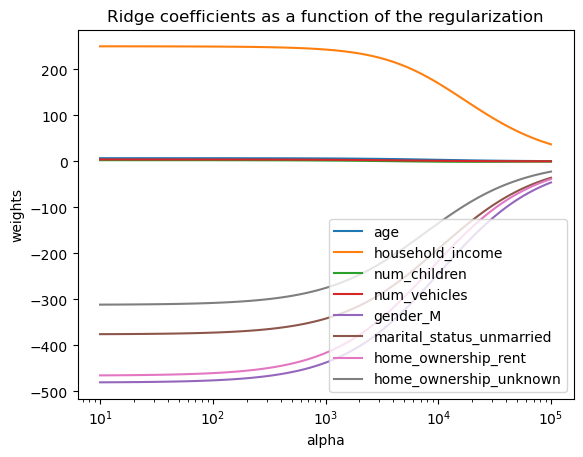

In [55]:
ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train_ss, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(train_X_ss.columns);

In [56]:
# Do a CV Ridge Regression to find best alpha
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(X_train_ss, y_train)

RidgeCV(alphas=array([1.00000000e+05, 9.11162756e+04, 8.30217568e+04, 7.56463328e+04,
       6.89261210e+04, 6.28029144e+04, 5.72236766e+04, 5.21400829e+04,
       4.75081016e+04, 4.32876128e+04, 3.94420606e+04, 3.59381366e+04,
       3.27454916e+04, 2.98364724e+04, 2.71858824e+04, 2.47707636e+04,
       2.25701972e+04, 2.05651231e+04, 1.87381742e+04, 1.70735265e+04,
       1.55567614e+04, 1.41747416e+0...
       8.49753436e+01, 7.74263683e+01, 7.05480231e+01, 6.42807312e+01,
       5.85702082e+01, 5.33669923e+01, 4.86260158e+01, 4.43062146e+01,
       4.03701726e+01, 3.67837977e+01, 3.35160265e+01, 3.05385551e+01,
       2.78255940e+01, 2.53536449e+01, 2.31012970e+01, 2.10490414e+01,
       1.91791026e+01, 1.74752840e+01, 1.59228279e+01, 1.45082878e+01,
       1.32194115e+01, 1.20450354e+01, 1.09749877e+01, 1.00000000e+01]),
        scoring='neg_mean_squared_error')

In [57]:
# Best alpha?
ridgecv.alpha_

23.10129700083158

In [58]:
# Create a Ridge Regression with the found alpha
rba = Ridge(alpha=ridgecv.alpha_)
rba.fit(X_train_ss, y_train)

Ridge(alpha=23.10129700083158)

In [59]:
pd.Series(rba.coef_, index=train_X_ss.columns)

age                           6.854857
household_income            250.067081
num_children                  2.546341
num_vehicles                  4.115594
gender_M                   -479.896063
marital_status_unmarried   -375.303195
home_ownership_rent        -464.701949
home_ownership_unknown     -311.035556
dtype: float64

## Lasso

Let's try Lasso

In [61]:
alphas2 = 10**np.linspace(3,1,100)

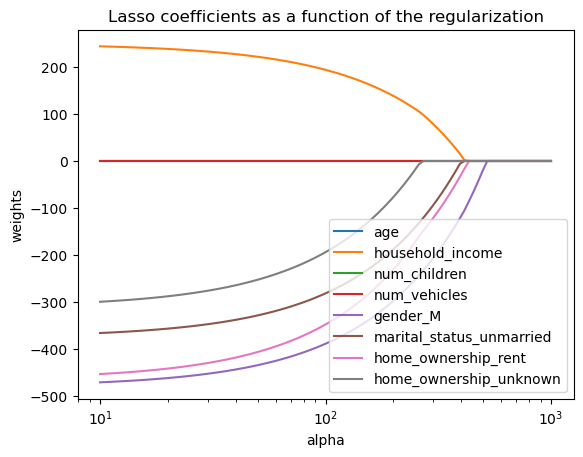

In [67]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas2:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_ss, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas2, coefs)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.legend(train_X_ss.columns);

In [63]:
# Create a Lasso with default alpha
lasso1 = Lasso()
lasso1.fit(X_train_ss, y_train)
lasso1.coef_

array([   5.85665848,  249.61318161,    1.5312618 ,    3.13949825,
       -480.08959711, -375.22522859, -464.80925078, -310.80257161])

In [68]:
# LassoCV
lassocv = LassoCV(alphas=alphas2, max_iter=10000)
lassocv.fit(X_train_ss, y_train)

LassoCV(alphas=array([1000.        ,  954.54845666,  911.16275612,  869.74900262,
        830.21756813,  792.48289835,  756.46332755,  722.08090184,
        689.26121043,  657.93322466,  628.02914418,  599.48425032,
        572.23676594,  546.22772177,  521.4008288 ,  497.70235643,
        475.08101621,  453.48785081,  432.87612811,  413.20124001,
        394.42060594,  376.49358068,  359.38136638,  343.04692863,
        327.45491629,  312.5715849...
         42.29242874,   40.37017259,   38.53528594,   36.78379772,
         35.11191734,   33.51602651,   31.99267138,   30.53855509,
         29.15053063,   27.82559402,   26.56087783,   25.35364494,
         24.20128265,   23.101297  ,   22.0513074 ,   21.04904145,
         20.09233003,   19.17910262,   18.3073828 ,   17.475284  ,
         16.68100537,   15.92282793,   15.19911083,   14.50828778,
         13.84886371,   13.21941148,   12.61856883,   12.0450354 ,
         11.49756995,   10.97498765,   10.47615753,   10.        ]),
        max_iter=10000)

In [69]:
# Best alpha for LassoCV
lassocv.alpha_

10.0

In [70]:
# Coefficients
lassocv.coef_

array([   0.        ,  244.4753536 ,    0.        ,    0.        ,
       -471.89985104, -366.78309089, -454.26493392, -300.1614742 ])

## ElasticNet

In [71]:
# Create an ElasticNet using default parameters
en = ElasticNet()
# fit it
en.fit(X_train_ss, y_train)
# Look at the estimated coefficients
en.coef_

array([   4.32555925,  207.96585605,    0.        ,    1.64830401,
       -325.19098302, -253.40739286, -296.56219742, -188.90769358])

In [72]:
# Create an ElasticNetCV to find best alpha
enCV = ElasticNetCV(cv=5, alphas=alphas, max_iter=10000)
enCV.fit(X_train_ss, y_train)

ElasticNetCV(alphas=array([1.00000000e+05, 9.11162756e+04, 8.30217568e+04, 7.56463328e+04,
       6.89261210e+04, 6.28029144e+04, 5.72236766e+04, 5.21400829e+04,
       4.75081016e+04, 4.32876128e+04, 3.94420606e+04, 3.59381366e+04,
       3.27454916e+04, 2.98364724e+04, 2.71858824e+04, 2.47707636e+04,
       2.25701972e+04, 2.05651231e+04, 1.87381742e+04, 1.70735265e+04,
       1.55567614e+04, 1.417474...
       8.49753436e+01, 7.74263683e+01, 7.05480231e+01, 6.42807312e+01,
       5.85702082e+01, 5.33669923e+01, 4.86260158e+01, 4.43062146e+01,
       4.03701726e+01, 3.67837977e+01, 3.35160265e+01, 3.05385551e+01,
       2.78255940e+01, 2.53536449e+01, 2.31012970e+01, 2.10490414e+01,
       1.91791026e+01, 1.74752840e+01, 1.59228279e+01, 1.45082878e+01,
       1.32194115e+01, 1.20450354e+01, 1.09749877e+01, 1.00000000e+01]),
             cv=5, max_iter=10000)

In [73]:
# best alpha for elasticnetcv
enCV.alpha_

10.0

In [74]:
# Build ElasticNet with best alpha
en2 = ElasticNet(alpha=enCV.alpha_)
en2.fit(X_train_ss, y_train)
en2.coef_

array([  0.17925189,  66.02263015,  -0.        ,   0.        ,
       -84.04154434, -65.13034574, -71.00639093, -41.31660856])

In [75]:
# Make predictions with the ElasticNet model en2
en2.predict(s_scaler.transform(X_test))

array([4092.68113599, 4206.01533148, 4192.97097213, ..., 4125.72712805,
       4339.10821095, 4368.79986674])

In [78]:
y_test.iloc[1]

3050

In [79]:
# Find the RMSE of that model
np.sqrt(mean_squared_error(y_test, en2.predict(s_scaler.transform(X_test))))

1500.7570203732662

In [80]:
s_scaler.scale_

array([1.06942476e+01, 1.15000996e+05, 1.70478965e+00, 1.69315606e+00,
       4.64686934e-01, 4.33833351e-01, 4.35570940e-01, 2.98334969e-01])

In [81]:
my_model = LinearRegression()
my_model

LinearRegression()

In [84]:
five_features = new_X_train.drop(columns=['const'])
five_features

,household_income,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
0,1.267258,1.473185,1.725486,-0.584255,-0.331026
1,-0.974774,1.473185,1.725486,-0.584255,-0.331026
2,-2.003922,-0.678801,-0.579547,1.711583,-0.331026
3,1.622960,-0.678801,-0.579547,-0.584255,-0.331026
4,0.469891,-0.678801,1.725486,-0.584255,-0.331026
...,...,...,...,...,...
9807,-0.940331,1.473185,-0.579547,-0.584255,-0.331026
9808,-0.538569,-0.678801,-0.579547,-0.584255,-0.331026
9809,-0.063287,-0.678801,-0.579547,-0.584255,-0.331026
9810,0.435040,1.473185,-0.579547,-0.584255,-0.331026


In [88]:
my_model.fit(five_features, y_train)

LinearRegression()

In [89]:
print(f'Intercept:    {my_model.intercept_}')
print(f'Coefficients: {my_model.coef_}')

Intercept:    4160.279351814105
Coefficients: [ 250.04203132 -481.04081646 -376.17781042 -466.01787133 -311.91387113]


In [98]:
X_test_scaled = s_scaler.transform(X_test)
df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
df

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
0,1.697328,-1.025878,0.876586,-0.888448,-0.678801,1.725486,-0.584255,-0.331026
1,-1.014410,0.893340,1.463169,-0.888448,-0.678801,-0.579547,1.711583,-0.331026
2,1.416804,0.317649,-0.296579,-0.297835,-0.678801,-0.579547,-0.584255,3.020911
3,-0.172836,1.591577,0.290003,1.474004,-0.678801,1.725486,-0.584255,-0.331026
4,0.575230,-1.204572,-0.296579,1.474004,1.473185,-0.579547,-0.584255,-0.331026
...,...,...,...,...,...,...,...,...
2449,1.510312,1.046339,1.463169,-1.479061,-0.678801,1.725486,-0.584255,-0.331026
2450,0.481722,1.178894,0.876586,0.292778,1.473185,-0.579547,-0.584255,-0.331026
2451,-1.668967,-0.320954,1.463169,0.883391,-0.678801,-0.579547,1.711583,-0.331026
2452,-1.388443,0.441083,0.290003,-0.297835,-0.678801,-0.579547,-0.584255,-0.331026


In [99]:
five_features_X_test = df.drop(columns=['age','num_children','num_vehicles'])
five_features_X_test

,household_income,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
0,-1.025878,-0.678801,1.725486,-0.584255,-0.331026
1,0.893340,-0.678801,-0.579547,1.711583,-0.331026
2,0.317649,-0.678801,-0.579547,-0.584255,3.020911
3,1.591577,-0.678801,1.725486,-0.584255,-0.331026
4,-1.204572,1.473185,-0.579547,-0.584255,-0.331026
...,...,...,...,...,...
2449,1.046339,-0.678801,1.725486,-0.584255,-0.331026
2450,1.178894,1.473185,-0.579547,-0.584255,-0.331026
2451,-0.320954,-0.678801,-0.579547,1.711583,-0.331026
2452,0.441083,-0.678801,-0.579547,-0.584255,-0.331026


In [100]:
pred = my_model.predict(five_features_X_test)
rSquare = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print(f'Test R-squared is: {rSquare:.2%}')
print(f'      and MSE is:  {mse:.2f}')
print(f'      and RMSE is: {rmse:.2f}')

Test R-squared is: 31.04%
      and MSE is:  1725988.36
      and RMSE is: 1313.77


**&copy; 2022 - Present: Matthew D. Dean, Ph.D.   
Clinical Associate Professor of Business Analytics at William \& Mary.**